In [1]:
#importing useful libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
import copy
from types import SimpleNamespace

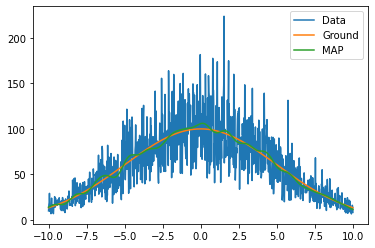

In [2]:
PARAMETERS = {

    #Knowns for Ground Truth
    'grndAlpha': 10,
    'grndMean': 0,
    'grndSigma': 5,
    'grndMag': 1000,
    'grndY': None,

    #General Knowns
    'nData': 1000,
    'nIndu': 50,
    'nFine': 5000,
    'covLambda': 10,
    'covL': 1,

    #Knowns to be evaluated
    'data': None,
    'xData': None,
    'xIndu': None,
    'xFine': None,
    'cInduIndu': None,
    'cInduData': None,
    'cInduFine': None,
    'cInduInduInv': None,

    # Variables
    'P': None,
    'alpha': None,
    'fIndu': None,

    # Priors
    'ell': 1,
    'sig': 10,
    'fInduMean': 0,
    'alphaShape': 2,
    'alphaScale': None,


    # Sampler parameters
    'epsilon': 1e-3,
    'fInduPropShape': .1,
}

# function to initialize all parameters that are not known or variable
def initialization(parameters):

    #declare variables as object of 
    variables = SimpleNamespace(**parameters)

    # extract knowns
    grndAlpha = variables.grndAlpha
    grndMean = variables.grndMean
    grndSigma = variables.grndSigma
    grndMag = variables.grndMag
    nData = variables.nData
    covLambda = variables.covLambda
    covL = variables.covL
    epsilon = variables.epsilon
    

    # sample Data
    variables.xData, variables.grndY, variables.data = curveFinder.dataGenerator(nData, grndMean, grndSigma, grndMag, grndAlpha)

    #define x vectors based on data
    variables.xIndu = np.linspace(np.min(variables.xData), np.max(variables.xData), variables.nIndu)
    variables.xFine = np.linspace(np.min(variables.xData), np.max(variables.xData), variables.nFine)

    #detrmine Covarince matrices
    variables.cInduIndu = curveFinder.covMat(variables.xIndu, variables.xIndu, covLambda, covL)
    variables.cInduData = curveFinder.covMat(variables.xIndu, variables.xData, covLambda, covL)
    variables.cInduFine = curveFinder.covMat(variables.xIndu, variables.xFine, covLambda, covL)
    variables.cInduInduInv = np.linalg.inv(variables.cInduIndu + epsilon*np.eye(variables.nIndu))
    
    
    #Initial sample for inducing points
    variables.fIndu = np.ones(variables.nIndu) * np.mean(variables.data)

    #Is this next line necassary?
    variables.alphaScale = np.mean(variables.data)/variables.alphaShape

    return variables

def curveSampler(variables):

    np.random.multivariate_normalpdf

    return variables
class curveFinder:
    
    '''This method creates synthetic data assuming gamma noise on a function with gaussian form'''
    @staticmethod
    def dataGenerator(length, mean, sigma, mag, alpha):
        
        def function(x, mean, sigma):

            y = mag*(math.e**((-1*(x - mean)**2)/(2*sigma**2)))
            return y

        xground = np.linspace(-10, 10, length)
        yground = function(xground, mean, sigma)

        data = np.random.gamma(alpha, yground/alpha, len(yground))
        return xground, yground, data
    @staticmethod
    def covMat(x, y, covLambda, covL):
        #Create empty matrix for covariance
        C = np.zeros((len(x), len(y)))
        
        #loop over all indecies in covariance matrix
        for i in range(len(x)):
            for j in range(len(y)):
                #Determine each element of covariance matrix
                C[i][j] = (covLambda**2)*(math.exp(((-1)*((x[i]-y[j])**2))/(covL**2)))

        #Return Covariance Matrix
        return C

    @staticmethod
    def matGenerator(nIndPts, xvect, nfine):
        
        def kernal(x, y):

            #Define constants for square kernal
            lambd = 10
            lexp = 1
            
            #Create empty matrix for covariance
            C = np.zeros((len(x), len(y)))
            
            #loop over all indecies in covariance matrix
            for i in range(len(x)):
                for j in range(len(y)):
                    #Determine each element of covariance matrix
                    C[i][j] = (lambd**2)*(math.exp(((-1)*((x[i]-y[j])**2))/(lexp**2)))
    
            #Return Covariance Matrix
            return C

        xindPts = np.linspace(-10, 10, nIndPts)
        xfine = np.linspace(-10, 10, nfine)
        C1 = kernal(xindPts, xvect)
        C2 = kernal(xvect, xindPts)
        C3 = kernal(xindPts, xindPts)
        C4 = kernal(xvect, xvect)
        C5 = kernal(xfine, xindPts)

        return C1, C2, C3, C4, C5

    @staticmethod
    def mvMeanCov(C1, C2, C3, C4, data, var):

        M = (1/var)*np.dot(np.linalg.inv(C3), np.dot(C1, np.dot(C2, np.linalg.inv(C3))))
        b = b = (1/var)*np.dot(np.linalg.inv(C3), np.dot(C1, data))

        mean = np.dot(np.linalg.inv(np.linalg.inv(C3) + M), b)
        covariance = np.linalg.inv(np.linalg.inv(C3) + M)

        return mean, covariance

    @staticmethod
    def sampler(mean, covariance, nSamples):

        samples = np.random.multivariate_normal(mean, covariance, size = nSamples)

        return samples

    @staticmethod
    def MAP(samples):

        return np.mean(samples, axis = 0)

    @staticmethod
    def fineGrid(map, Cind, Cfine):
        
        fineMAP = np.dot(Cfine, np.dot(np.linalg.inv(Cind), map))

        return fineMAP





mean = 0
sigma = 5
var = 10
nData = 1000
nInd = 55
nsamples = 100
nfine = 500
mag = 100
alpha = 10
x, yground, data = curveFinder.dataGenerator(nData, mean, sigma, mag, alpha)



C1, C2, C3, C4, C5 = curveFinder.matGenerator(nInd, x, nfine)

mutilda, ctilda = curveFinder.mvMeanCov(C1, C2, C3, C4, data, var)

samples = curveFinder.sampler(mutilda, ctilda, nsamples)
map = curveFinder.MAP(samples)
fineMAP = curveFinder.fineGrid(map, C3, C5)

plt.plot(x, data, label = "Data")
plt.plot(x, yground, label = "Ground")
#plt.plot(np.linspace(-15, -1, nInd), map)
plt.plot(np.linspace(-10, 10, nfine), fineMAP, label = "MAP")
plt.legend()

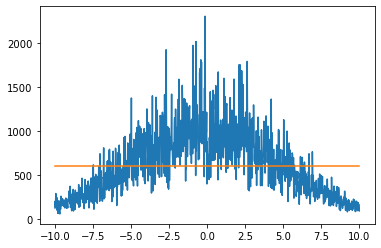

In [3]:
#parameters = {**PARAMETERS, **parameters}

# Initialize variables
variables = initialization(PARAMETERS)
plt.plot(x, variables.data, label = "Data")
plt.plot(variables.xIndu, variables.fIndu, label = "Ground")